<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-results" data-toc-modified-id="Load-results-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load results</a></span></li><li><span><a href="#Contribution-to-total-precipitation" data-toc-modified-id="Contribution-to-total-precipitation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Contribution to total precipitation</a></span></li><li><span><a href="#Hourly-extremes-at-native-resolution" data-toc-modified-id="Hourly-extremes-at-native-resolution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hourly extremes at native resolution</a></span><ul class="toc-item"><li><span><a href="#Vertical-profiles" data-toc-modified-id="Vertical-profiles-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Vertical profiles</a></span></li></ul></li></ul></div>

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

import pandas as pd
import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib.pyplot as plt
from matplotlib import mplDeprecation
import datetime as dt
import sys,os,glob
import matplotlib
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
import pickle

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from importingData import *
from scalingApproximations import *
from plotMaps import *
from plot1DInvLog import *
from statisticalDistributions import *
from slicingAndSubsetting import *
from outputResults import *
from CAMsettings import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['plot2D', 'daskOptions', 'slicingAndSubsetting', 'outputResults', 'CAMsettings', 'thermoFunctions', 'thermoConstants', 'environmentAndDirectories', 'plotMaps', 'physicalConstants', 'importingData', 'scalingApproximations', 'plot1DInvLog', 'statisticalDistributions']


In [3]:
time_strides = '1h','3h','6h','12h','1d','2d','4d','8d'
resolutions = '1dx','2dx','3dx','4dx','5dx','6dx','7dx','8dx','9dx'

ranks_label = 'Q8-Q41'
dates_label = '185005010100-185105010000'
dates_label2 = '185005010100-185009010000'

In [112]:
print("choose run options")
scaling = 'omega500tsps'
# compset = 'FSPCAMm_AMIP'
compset = 'FAMIPC5'
experiment = 'piControl'
member = 'r1i1p1'
subset = 'tropics'
time_ref = '1h'
res_ref = '1dx'
daskarray = False

time_show = '1h'
# time_show = '1d'
res_show = '1dx'

choose run options


In [115]:
# Results to analyze
resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset)
resultdir_PI = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,'piControl',member,subset)
resultdir_4xCO2 = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,'abrupt4xCO2',member,subset)

# Figure output directory
figdir = os.path.join(os.path.dirname(workdir),'figures','paper')

print()
print("get inputpaths")

# Local input directory
historyFilesSettings = getCAMHistoryFilesSettings()
inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)


get inputpaths


In [116]:
print("load physical variables data")

omega_id = 'OMEGA'
pr_id = 'PRECT'
ts_id = 'TS'
ta_id = 'T'
relhum_id = 'RELHUM'
spechum_id = 'Q'
ps_id = 'PS'
dates_maps = '185005010100','185005080000'
handle = 'h0'

output_suffix_maps = '%s'%('-'.join(dates_maps))

omega,pr,ta,relhum,spechum,ps = \
    getValues([omega_id,pr_id,ta_id,relhum_id,spechum_id,ps_id],
              compset,subset,experiment,time_show,res_show,
              daskarray=daskarray,dates=dates_maps,handle=handle)
pr *= rho_l    # convert from m/s to kg/m2/s

print("compute pressure levels")
    
input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)
pres = computeP(ps)


load physical variables data
No simulation history file found for dates 185005010100-185005080000 in /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl.


TypeError: object of type 'NoneType' has no len()

# Load results

In [101]:
print("Load results as a dictionary")
results = {}
for time_stride in time_strides:
    results[time_stride] = {}
    for resolution in resolutions:
        filename = 'results_dictionary_%s_%s.pickle'%(ranks_label,dates_label)
        filepath = os.path.join(resultdir,time_stride,resolution,filename)
        results[time_stride][resolution] = pickle.load(open(filepath,'rb'))

all_varids = results[time_ref][res_ref].keys()

Load results as a dictionary


In [102]:
results_PI = {}
# results_4xCO2 = {}
for time_stride in time_strides:
    results_PI[time_stride] = {}
#     results_4xCO2[time_stride] = {}
    for resolution in resolutions:
        filename = 'results_dictionary_%s_%s.pickle'%(ranks_label,dates_label)
        filepath_PI = os.path.join(resultdir_PI,time_stride,resolution,filename)
#         filepath_4xCO2 = os.path.join(resultdir_4xCO2,time_stride,resolution,filename)
        results_PI[time_stride][resolution] = pickle.load(open(filepath_PI,'rb'))
#         results_4xCO2[time_stride][resolution] = pickle.load(open(filepath_4xCO2,'rb'))

# Contribution to total precipitation
!! Make sure you load daily precipitation values before executing this code

In [103]:
results_dict_day = results[time_show][res_show]

In [104]:
ranks_ref = results_dict_day['ranks_ref']
pr_amount_above_prQ = np.ones(ranks_ref.size)
for rank in ranks_ref:
    iQ = indexOfRank(rank,ranks_ref)
    prQ = results_dict_day['percentiles'][iQ]
    if not np.isnan(prQ):
        print(rank, prQ, np.nansum(pr[pr>prQ])/np.nansum(pr))
        pr_amount_above_prQ[iQ] = np.nansum(pr[pr>prQ])/np.nansum(pr)
    else:
        print(rank,1)

0.0 1
20.5671765276 6.22823712011e-09 0.999998
36.904265552 1.39972622521e-06 0.998118
49.8812766373 4.76565360213e-06 0.98759
60.1892829447 8.98850381488e-06 0.967195
68.3772233983 1.42532414249e-05 0.941147
74.8811356849 2.14873019022e-05 0.909978
80.0473768503 3.22294188708e-05 0.866041
84.1510680754 4.81790231422e-05 0.814853
87.4107458821 6.97147779665e-05 0.757236
90.0 9.70018198132e-05 0.692319
92.0567176528 0.000129451549535 0.622162
93.6904265552 0.000166518512252 0.531026
94.9881276637 0.000206872754846 0.459208
96.0189282945 0.000249527342096 0.390731
96.8377223398 0.000294674504269 0.318381
97.4881135685 0.000340047252284 0.258915
98.004737685 0.000384812276423 0.224999
98.4151068075 0.00043000729666 0.189519
98.7410745882 0.000474394582297 0.164309
99.0 0.000518803229206 0.13568
99.2056717653 0.000561721686099 0.125685
99.3690426555 0.000603785501469 0.107459
99.4988127664 0.000645765781874 0.0801925
99.6018928294 0.00068661649135 0.0676881
99.683772234 0.000729686524944 0

> Plot fraction of rain amount above each percentile
resolution: 1d
% above P90 (0.000097 kg/m2/s) : 69.2318737507
% above P99 (0.000519 kg/m2/s) : 13.5680317879


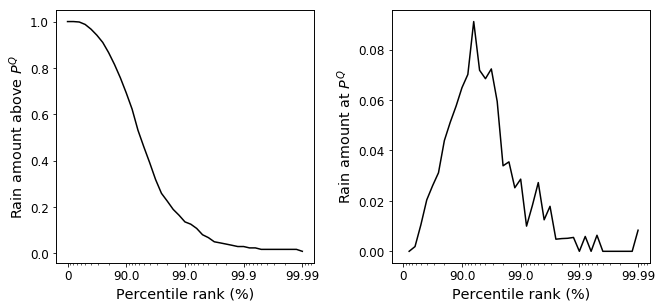

In [105]:
print("> Plot fraction of rain amount above each percentile")
print("resolution:",time_show)

fig, (ax,axx) = plt.subplots(ncols=2,nrows=1,figsize=(11,4.5))

# ax.set_yscale('log')

# Add zero line
addZeroLine(ax,ranks_ref)
addZeroLine(axx,ranks_ref)

pr_amount_prQ = -np.diff(pr_amount_above_prQ)

subplotRanksILog(ax,ranks_ref,
                 pr_amount_above_prQ,
                 col='k',ltype='-',transformX=True)
subplotRanksILog(axx,ranks_ref[:-1],
                 pr_amount_prQ,
                 col='k',ltype='-',transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Rain amount above $P^Q$')
axx.set_xlabel('Percentile rank (%)')
axx.set_ylabel(r'Rain amount at $P^Q$')

# plt.savefig(os.path.join(figdir,'sample_size_in_P_bins_%s.pdf'%output_suffix),
#             bbox_inches='tight')

i90 = indexOfRank(90,ranks_ref)
i99 = indexOfRank(99,ranks_ref)
print("%% above P90 (%1.6f"%results_dict_day['percentiles'][i90],"kg/m2/s) :",pr_amount_above_prQ[i90]*100)
print("%% above P99 (%1.6f"%results_dict_day['percentiles'][i99],"kg/m2/s) :",pr_amount_above_prQ[i99]*100)

plt.show()

# Hourly extremes at native resolution

In [106]:
print("choose one scale")
results_dict = results[time_show][res_show]

choose one scale


In [107]:
ranks_ref = results_dict['ranks_ref']
i_Q = indexOfRank(99.9,ranks_ref)
iQ_slice = slice(i_Q-5,i_Q+5)
iQ_min = 8
iQ_max = len(results_dict['ranks_ref'])

output_suffix_1scale = '%s_%s_%s'%(experiment,compset,dates_label)

## Vertical profiles

In [108]:
ranks, centers, bins = computePercentilesAndBinsFromRanks(pr.flatten(),ranks_ref)
percentiles = adjustRanks(centers,ranks,ranks_ref)

rank_locations= {}
for rank in ranks_ref:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations[rank_id] = getRankLocations(rank,pr,ranks,bins,rank_locations)
print()


0.0000 20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 99.9900 


In [109]:
print("Extract vertical profiles in Q-slice")

iQ_slice_profiles = slice(i_Q,i_Q+1)
iQ_ref = range(100)[iQ_slice_profiles]


varnames_for_profiles = ('omega','ta','pres','relhum','spechum')

ranks_tune = ["%2.4f"%(ranks_ref[iQ-1]) for iQ in iQ_ref]
# Initialize list for each variable
for varname in varnames_for_profiles:
    setattr(thismodule,"%s_ref_list"%varname,[])
# fill list with sample variables at each percentile
for rank in ranks_tune:
    stencil_Q = rank_locations[rank]
    for varname in varnames_for_profiles:
        var = getattr(thismodule,varname)
        var_list = getattr(thismodule,"%s_ref_list"%varname)
        var_list.append(sampleFlattened(var,stencil_Q))
# concat arrays from list
for varname in varnames_for_profiles:
    var_list = getattr(thismodule,"%s_ref_list"%varname)
    setattr(thismodule,"%s_ref"%varname,np.hstack(var_list))

qvstar_ref = saturationSpecificHumidity(ta_ref,pres_ref)

Extract vertical profiles in Q-slice


In [110]:
relhum_ref_2 = spechum_ref/qvstar_ref*100

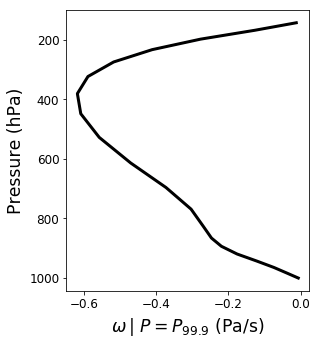

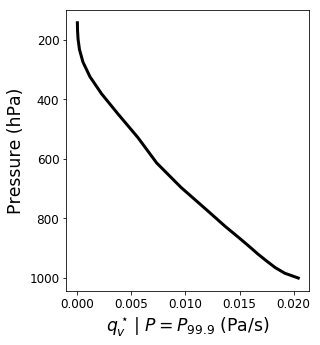

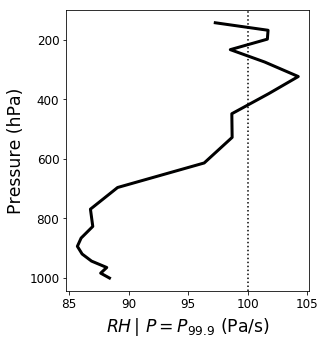

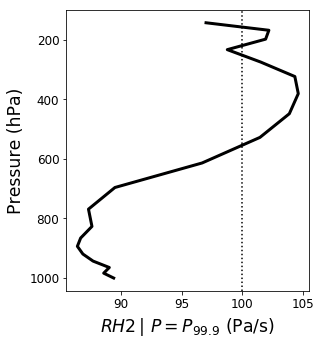

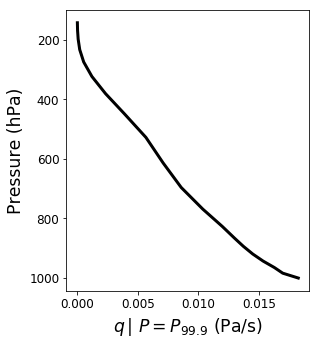

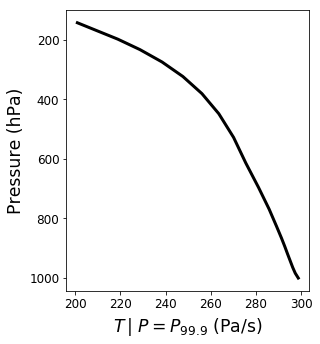

In [111]:
vars_to_plot = 'omega_ref','qvstar_ref','relhum_ref','relhum_ref_2','spechum_ref','ta_ref'
labs = '\omega','q_v^\star','RH','RH2','q','T'
nvars_to_plot = len(vars_to_plot)

v_slice = slice(10,None)

# fig, axs = plt.subplots(ncols=nvars_to_plot,nrows=1,figsize=(6*nvars_to_plot-1,5))

for iplot in range(nvars_to_plot):
    
#     ax = axs[iplot]
    fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(4.5,5))
    
    var_name = vars_to_plot[iplot]
    var_to_plot = getattr(thismodule,var_name).copy()
    for i in range(var_to_plot.shape[1])[:]:
        ax.plot(var_to_plot[v_slice,i],pres_ref[v_slice,i]/100)
    ax.invert_yaxis()
    ax.set_xlabel(r'$%s \,|\,\, P=P_{99.9}$ (Pa/s)'%labs[iplot],fontsize='xx-large')
    ax.set_ylabel('Pressure (hPa)',fontsize='xx-large')
    
    ax.plot(np.mean(var_to_plot,axis=1)[v_slice],np.mean(pres_ref,axis=1)[v_slice]/100,
                   linewidth=3,c='k')

    if var_name in ['relhum_ref','relhum_ref_2']:
        ax.axvline(100,c='k',linestyle=':')
    elif var_name in ['qvstar_ref','spechum_ref']:
        pass
#         ax.set_xscale('log')
        
    plt.savefig(os.path.join(figdir,'paper_%s_profiles_Q999_%s_%s_%s_%s_%s.pdf'%(var_name,experiment,
                                                                                     compset,
                                                                                     res_show,
                                                                                     time_show,
                                                                                     output_suffix_1scale)),
            bbox_inches='tight')
    
# plt.savefig(os.path.join(figdir,'paper_omega_q_RH_profiles_Q999_%s_%s_%s_%s_%s.pdf'%(experiment,
#                                                                                      compset,
#                                                                                      res_show,
#                                                                                      time_show,
#                                                                                      output_suffix_1scale)),
#             bbox_inches='tight')

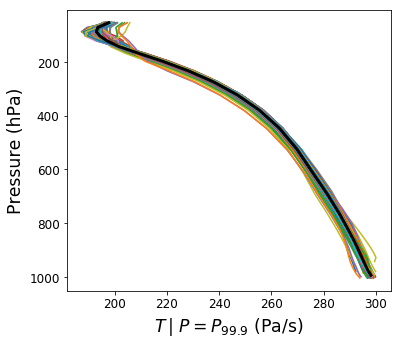

In [29]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6,5))

var_name = 'ta_ref'
var_to_plot = getattr(thismodule,var_name).copy()
for i in range(var_to_plot.shape[1])[:]:
    ax.plot(var_to_plot[5:,i],pres_ref[5:,i]/100)
ax.invert_yaxis()
ax.set_xlabel(r'$T \,|\,\, P=P_{99.9}$ (Pa/s)',fontsize='xx-large')
ax.set_ylabel('Pressure (hPa)',fontsize='xx-large')

ax.plot(np.mean(var_to_plot,axis=1)[5:],np.mean(pres_ref,axis=1)[5:]/100,
               linewidth=3,c='k')
    
# plt.savefig(os.path.join(figdir,'paper_omega_q_RH_profiles_Q999_%s_%s_%s_%s_%s.pdf'%(experiment,
#                                                                                      compset,
#                                                                                      res_show,
#                                                                                      time_show,
#                                                                                      output_suffix_1scale)),
#             bbox_inches='tight')